In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import models
import matplotlib.pyplot as plt
from helper import *
torch.cuda.set_device(0)

In [2]:
classes = ['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'fence', 'car', 'pedestrian', 'bicyclist', 'unlabelled']
DATA_DIR = '../data/CamVid/'
x_train_dir = os.path.join(DATA_DIR, 'trainsmall')
y_train_dir = os.path.join(DATA_DIR, 'trainsmallannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.41189489566336, 0.4251328133025, 0.4326707089857], std = [0.27413549931506, 0.28506257482912, 0.28284674400252])
])

train_dataset = CamVid(
    x_train_dir,
    y_train_dir,
    classes = classes,
    transform = transform
)

valid_dataset = CamVid(
    x_valid_dir,
    y_valid_dir,
    classes = classes, 
    transform = transform
)

test_dataset = CamVid(
    x_test_dir,
    y_test_dir,
    classes = classes, 
    transform = transform
)

In [3]:
trainloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, drop_last = True)
valloader = DataLoader(valid_dataset, batch_size = 1, shuffle = False)
testloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [4]:
unet = models.unet.Unet('resnet18', classes = 12, encoder_weights = None).cuda()
unet.load_state_dict(torch.load('../saved_models/resnet18/pretrained.pt'))

<All keys matched successfully>

In [5]:
def mean_iou(model, dataloader) : 
    gpu1 = 'cuda:0'
    ious = list()
    for i, (data, target) in enumerate(dataloader) : 
        data, target = data.float().to(gpu1), target.long().to(gpu1)
        prediction = model(data)
        prediction = F.softmax(prediction, dim = 1)
        prediction = torch.argmax(prediction, axis = 1).squeeze(1)
        ious.append(iou(target, prediction, num_classes = 11))
        
    return (sum(ious) / len(ious))

In [6]:
print(mean_iou(unet, valloader))
print(mean_iou(unet, testloader))

0.5357400573392819
0.36408891822227735


In [7]:
unet = models.unet.Unet('resnet34', classes = 12, encoder_weights = None).cuda()
unet.load_state_dict(torch.load('../saved_models/resnet34/pretrained.pt'))

<All keys matched successfully>

In [8]:
print(mean_iou(unet, valloader))
print(mean_iou(unet, testloader))

0.5547654143631603
0.37584598449861767


In [44]:
def pixelwise_acc(mask1, mask2) :
    equals = (mask1 == mask2).sum().item()
    return equals / (mask1.shape[0] * mask1.shape[1] * mask1.shape[2])

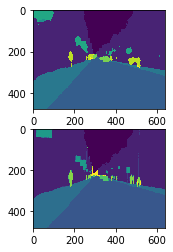

In [29]:
img, mask = next(iter(trainloader))
img, mask = img.cuda(0), mask.cuda(0)
out = unet(img)
out = F.softmax(out, dim = 1)
y = out.cpu().detach().numpy()
y = np.argmax(y, axis = 1)
mask_ = mask.cpu().detach().numpy()

fig, axes = plt.subplots(2, 1)
axes[0].imshow(y[0])
axes[1].imshow(mask_[0])

In [47]:
out2 = torch.argmax(out, dim = 1).squeeze(1)
print(out2.shape, mask.shape)
pixelwise_acc(out2, mask)

torch.Size([8, 480, 640]) torch.Size([8, 480, 640])


0.9293461100260416

In [5]:
def dice_coeff(mask1, mask2, smooth = 1e-6, num_classes = 19) : 
    dice = 0
    for sem_class in range(num_classes) : 
        pred_inds = (mask1 == sem_class)
        target_inds = (mask2 == sem_class)
        intersection = (pred_inds[target_inds]).long().sum().item()
        denom = pred_inds.long().sum().item() + target_inds.long().sum().item()
        dice += (float(2 * intersection) + smooth) / (float(denom) + smooth)
    return dice / num_classes

In [6]:
def avg_dice_coeff(model, dataloader) : 
    gpu1 = 'cuda:0'
    gpu2 = 'cuda:1'
    ious = list()
    for i, (data, target) in enumerate(dataloader) : 
        data, target = data.float().to(gpu1), target.long().to(gpu1)
        prediction = model(data)
        prediction = F.softmax(prediction, dim = 1)
        prediction = torch.argmax(prediction, axis = 1).squeeze(1)
        ious.append(dice_coeff(target, prediction, num_classes = 11))
        
    return (sum(ious) / len(ious))

In [7]:
avg_dice_coeff(unet, valloader)

0.6281462205043835

In [5]:
for model_name in ['resnet10', 'resnet14', 'resnet18', 'resnet20', 'resnet26', 'resnet34'] : 
    train_ious = list()
    val_ious = list()
    test_ious = list()
    unet = models.unet.Unet(model_name, classes = 12, encoder_weights = None).cuda()
    for i in range(3) : 
        unet.load_state_dict(torch.load('../saved_models/' + model_name + '/pretrained_' + str(i) + '.pt'))
        current_val_iou = mean_iou(unet, valloader)
        current_train_iou = mean_iou(unet, trainloader)
        current_test_iou = mean_iou(unet, testloader)
        train_ious.append(current_train_iou)
        val_ious.append(current_val_iou)
        test_ious.append(current_test_iou)
    train_mean = np.mean(train_ious)
    train_std_dev = np.std(train_ious)
    val_mean = np.mean(val_ious)
    val_std_dev = np.std(val_ious)
    test_mean = np.mean(test_ious)
    test_std_dev = np.std(test_ious)
    print(round(train_mean, 5), ' +- ', round(train_std_dev, 5), '----', round(val_mean, 5), ' +- ', round(val_std_dev, 5), '----', round(test_mean, 5), ' +- ', round(test_std_dev, 5))

0.63176  +-  0.01848 ---- 0.52617  +-  0.00872 ---- 0.35491  +-  0.00422
0.62573  +-  0.01292 ---- 0.5477  +-  0.00672 ---- 0.36425  +-  0.00472
0.64372  +-  0.0064 ---- 0.54241  +-  0.00485 ---- 0.36209  +-  0.00276
0.63487  +-  0.00806 ---- 0.53814  +-  0.01072 ---- 0.37006  +-  0.0038
0.65151  +-  0.01434 ---- 0.55949  +-  0.01342 ---- 0.37647  +-  0.00518
0.67577  +-  0.00784 ---- 0.60715  +-  0.00842 ---- 0.42734  +-  0.006


In [6]:
for i in range(3) : 
    unet = models.unet.Unet('resnet34', classes = 12, encoder_weights = None).cuda()
    unet.load_state_dict(torch.load('../saved_models/resnet34/pretrained_' + str(i) + '.pt'))
    current_val_iou = mean_iou(unet, valloader)
    current_train_iou = mean_iou(unet, trainloader)
    current_test_iou = mean_iou(unet, testloader)
    print(current_train_iou)
    print(current_val_iou)
    print(current_test_iou)

0.6888440573380167
0.6170405935881389
0.4356820135808164
0.6608705057992386
0.5964584916274905
0.42183620589369875
0.6773658402202525
0.6079386404367901
0.4244905592057309


In [5]:
unet = models.unet.Unet('resnet10', classes = 12, encoder_weights = None).cuda()
unet.load_state_dict(torch.load('../saved_models/resnet10/classifier/model0.pt'))
print(mean_iou(unet, trainloader))
print(mean_iou(unet, valloader))
print(mean_iou(unet, testloader))

0.6546765093381575
0.5977865289519019
0.4214258224376416


In [5]:
for model_name in ['resnet10', 'resnet14', 'resnet18', 'resnet20', 'resnet26'] : 
    train_ious = list()
    val_ious = list()
    test_ious = list()
    unet = models.unet.Unet(model_name, classes = 12, encoder_weights = None).cuda()
    for i in range(3) : 
        unet.load_state_dict(torch.load('../saved_models/' + model_name + '/classifier/model' + str(i) + '.pt'))
        current_val_iou = mean_iou(unet, valloader)
        current_train_iou = mean_iou(unet, trainloader)
        current_test_iou = mean_iou(unet, testloader)
        train_ious.append(current_train_iou)
        val_ious.append(current_val_iou)
        test_ious.append(current_test_iou)
    train_mean = np.mean(train_ious)
    train_std_dev = np.std(train_ious)
    val_mean = np.mean(val_ious)
    val_std_dev = np.std(val_ious)
    test_mean = np.mean(test_ious)
    test_std_dev = np.std(test_ious)
    print(round(train_mean, 5), ' +- ', round(train_std_dev, 5), '----', round(val_mean, 5), ' +- ', round(val_std_dev, 5), '----', round(test_mean, 5), ' +- ', round(test_std_dev, 5))

0.6535  +-  0.00065 ---- 0.59959  +-  0.00188 ---- 0.42046  +-  0.00141
0.65567  +-  0.00167 ---- 0.61364  +-  0.00061 ---- 0.42784  +-  0.00201
0.66328  +-  0.00157 ---- 0.60884  +-  0.00288 ---- 0.42486  +-  0.00078
0.6647  +-  0.00109 ---- 0.6082  +-  0.00163 ---- 0.42703  +-  0.00022
0.66226  +-  0.0004 ---- 0.60037  +-  0.00139 ---- 0.42656  +-  0.00113


In [7]:
for model_name in ['resnet10', 'resnet14', 'resnet18', 'resnet20', 'resnet26'] : 
    train_ious = list()
    val_ious = list()
    test_ious = list()
    unet = models.unet.Unet(model_name, classes = 12, encoder_weights = None).cuda()
    for i in range(3) : 
        unet.load_state_dict(torch.load('../saved_models/less_data/' + model_name + '/classifier/model' + str(i) + '.pt'))
        current_val_iou = mean_iou(unet, valloader)
        current_train_iou = mean_iou(unet, trainloader)
        current_test_iou = mean_iou(unet, testloader)
        train_ious.append(current_train_iou)
        val_ious.append(current_val_iou)
        test_ious.append(current_test_iou)
    train_mean = np.mean(train_ious)
    train_std_dev = np.std(train_ious)
    val_mean = np.mean(val_ious)
    val_std_dev = np.std(val_ious)
    test_mean = np.mean(test_ious)
    test_std_dev = np.std(test_ious)
    print(round(train_mean, 5), ' +- ', round(train_std_dev, 5), '----', round(val_mean, 5), ' +- ', round(val_std_dev, 5), '----', round(test_mean, 5), ' +- ', round(test_std_dev, 5))

0.62542  +-  0.00096 ---- 0.55015  +-  0.00484 ---- 0.38187  +-  0.00239
0.61828  +-  0.00688 ---- 0.56153  +-  0.00226 ---- 0.3925  +-  0.00252
0.63054  +-  0.00495 ---- 0.56978  +-  0.006 ---- 0.39678  +-  0.00043
0.62635  +-  0.00063 ---- 0.56548  +-  0.0072 ---- 0.39863  +-  0.00043
0.62772  +-  0.00471 ---- 0.56626  +-  0.00247 ---- 0.39943  +-  0.00244


In [ ]:
for perc in [10, 20, 30, 40] :
    x_train_dir = os.path.join(DATA_DIR, 'trainsmall' + str(perc))
    y_train_dir = os.path.join(DATA_DIR, 'trainsmallannot' + str(perc))
    train_dataset = CamVid(
        x_train_dir,
        y_train_dir,
        classes = classes,
        transform = transform
    )
    trainloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, drop_last = True)

    for model_name in ['resnet10', 'resnet14', 'resnet18', 'resnet20', 'resnet26'] : 
        train_ious = list()
        val_ious = list()
        test_ious = list()
        unet = models.unet.Unet(model_name, classes = 12, encoder_weights = None).cuda()
        for i in range(3) : 
            unet.load_state_dict(torch.load('../saved_models/less_data' + str(perc) + '/' + model_name + '/classifier/model' + str(i) + '.pt'))
            current_val_iou = mean_iou(unet, valloader)
            current_train_iou = mean_iou(unet, trainloader)
            current_test_iou = mean_iou(unet, testloader)
            train_ious.append(current_train_iou)
            val_ious.append(current_val_iou)
            test_ious.append(current_test_iou)
        train_mean = np.mean(train_ious)
        train_std_dev = np.std(train_ious)
        val_mean = np.mean(val_ious)
        val_std_dev = np.std(val_ious)
        test_mean = np.mean(test_ious)
        test_std_dev = np.std(test_ious)
        print(round(train_mean, 5), ' +- ', round(train_std_dev, 5), '----', round(val_mean, 5), ' +- ', round(val_std_dev, 5), '----', round(test_mean, 5), ' +- ', round(test_std_dev, 5))

#### Evaluation of Traditional KD with full dataset

In [10]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.41189489566336, 0.4251328133025, 0.4326707089857], std = [0.27413549931506, 0.28506257482912, 0.28284674400252])
])

train_dataset = CamVid(
    x_train_dir,
    y_train_dir,
    classes = classes,
    transform = transform
)

valid_dataset = CamVid(
    x_valid_dir,
    y_valid_dir,
    classes = classes, 
    transform = transform
)

test_dataset = CamVid(
    x_test_dir,
    y_test_dir,
    classes = classes, 
    transform = transform
)

trainloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, drop_last = True)
valloader = DataLoader(valid_dataset, batch_size = 1, shuffle = False)
testloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

for model_name in ['resnet10', 'resnet14', 'resnet18', 'resnet20', 'resnet26'] : 
    unet = models.unet.Unet(model_name, classes = 12, encoder_weights = None).cuda()
    unet.load_state_dict(torch.load('../saved_models/camvid/trad_kd/' + model_name + '/model0.pt'))
    current_val_iou = mean_iou(unet, valloader)
    current_train_iou = mean_iou(unet, trainloader)
    current_test_iou = mean_iou(unet, testloader)
    print(round(current_train_iou, 5), round(current_val_iou, 5), round(current_test_iou, 5))

0.64853 0.55583 0.37193
0.63207 0.55299 0.38704
0.61392 0.55576 0.37983
0.61879 0.50527 0.3567
0.60309 0.51407 0.35582


#### Evaluation of Traditional KD with fractional dataset

In [6]:
for perc in [10, 20, 30, 40] :
    x_train_dir = os.path.join(DATA_DIR, 'trainsmall' + str(perc))
    y_train_dir = os.path.join(DATA_DIR, 'trainsmallannot' + str(perc))
    train_dataset = CamVid(
        x_train_dir,
        y_train_dir,
        classes = classes,
        transform = transform
    )
    trainloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, drop_last = True)
    print('percentage: ', perc)
    for model_name in ['resnet10', 'resnet14', 'resnet18', 'resnet20', 'resnet26'] : 
        train_ious = list()
        val_ious = list()
        test_ious = list()
        unet = models.unet.Unet(model_name, classes = 12, encoder_weights = None).cuda()
        unet.load_state_dict(torch.load('../saved_models/camvid/less_data' + str(perc) + '/trad_kd/' + model_name + '/model0.pt'))
        current_val_iou = mean_iou(unet, valloader)
        current_train_iou = mean_iou(unet, trainloader)
        current_test_iou = mean_iou(unet, testloader)
        print('model: ', model_name)
        print(round(current_train_iou, 5), round(current_val_iou, 5), round(current_test_iou, 5))

percentage:  10
model:  resnet10
0.33353 0.25293 0.2306
model:  resnet14
0.36537 0.28911 0.247
model:  resnet18
0.35355 0.26334 0.24498
model:  resnet20
0.34641 0.23383 0.2309
model:  resnet26
0.35703 0.27662 0.24255
percentage:  20
model:  resnet10
0.39709 0.3285 0.26558
model:  resnet14
0.38971 0.32868 0.27529
model:  resnet18
0.4023 0.33936 0.27953
model:  resnet20
0.4123 0.33812 0.2688
model:  resnet26
0.38988 0.3105 0.25078
percentage:  30
model:  resnet10
0.44408 0.35192 0.2833
model:  resnet14
0.4574 0.38642 0.29293
model:  resnet18
0.42197 0.38238 0.27754
model:  resnet20
0.44397 0.39396 0.28697
model:  resnet26
0.43627 0.35542 0.28541
percentage:  40
model:  resnet10
0.51495 0.42759 0.30368
model:  resnet14
0.52595 0.42193 0.30817
model:  resnet18
0.49122 0.42616 0.30294
model:  resnet20
0.46955 0.40827 0.30043
model:  resnet26
0.49713 0.43863 0.3088


#### Evaluation of standalone training with fraction of data

In [9]:
for perc in [10, 20, 30, 40] :
    x_train_dir = os.path.join(DATA_DIR, 'trainsmall' + str(perc))
    y_train_dir = os.path.join(DATA_DIR, 'trainsmallannot' + str(perc))
    train_dataset = CamVid(
        x_train_dir,
        y_train_dir,
        classes = classes,
        transform = transform
    )
    trainloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, drop_last = True)
    print('perc : ', perc)
    for model_name in ['resnet10', 'resnet14', 'resnet18', 'resnet20', 'resnet26'] : 
        print('model : ', model_name)
        train_ious = list()
        val_ious = list()
        test_ious = list()
        unet = models.unet.Unet(model_name, classes = 12, encoder_weights = None).cuda()
        for i in range(3) : 
            unet.load_state_dict(torch.load('../saved_models/camvid/less_data/' + model_name + '/pretrained_' + str(perc) + '_' + str(i) + '.pt'))
            current_val_iou = mean_iou(unet, valloader)
            current_train_iou = mean_iou(unet, trainloader)
            current_test_iou = mean_iou(unet, testloader)
            train_ious.append(current_train_iou)
            val_ious.append(current_val_iou)
            test_ious.append(current_test_iou)
        train_mean = np.mean(train_ious)
        train_std_dev = np.std(train_ious)
        val_mean = np.mean(val_ious)
        val_std_dev = np.std(val_ious)
        test_mean = np.mean(test_ious)
        test_std_dev = np.std(test_ious)
        print(round(train_mean, 5), ' +- ', round(train_std_dev, 5), '----', round(val_mean, 5), ' +- ', round(val_std_dev, 5), '----', round(test_mean, 5), ' +- ', round(test_std_dev, 5))

perc :  10
model :  resnet10
0.35172  +-  0.00724 ---- 0.25953  +-  0.01908 ---- 0.22803  +-  0.00616
model :  resnet14
0.35933  +-  0.00434 ---- 0.26859  +-  0.00857 ---- 0.23766  +-  0.00483
model :  resnet18
0.36886  +-  0.00521 ---- 0.26705  +-  0.02723 ---- 0.23669  +-  0.00859
model :  resnet20
0.35547  +-  0.01504 ---- 0.26502  +-  0.02425 ---- 0.24018  +-  0.00952
model :  resnet26
0.36588  +-  0.00516 ---- 0.26088  +-  0.01691 ---- 0.2421  +-  0.00417
perc :  20
model :  resnet10
0.39674  +-  0.00505 ---- 0.31366  +-  0.00945 ---- 0.25953  +-  0.001
model :  resnet14
0.39985  +-  0.00263 ---- 0.3194  +-  0.00492 ---- 0.26274  +-  0.00404
model :  resnet18
0.40056  +-  0.01402 ---- 0.32341  +-  0.00545 ---- 0.26703  +-  0.00799
model :  resnet20
0.40694  +-  0.00893 ---- 0.33271  +-  0.01685 ---- 0.26685  +-  0.00318
model :  resnet26
0.39635  +-  0.00507 ---- 0.34098  +-  0.00898 ---- 0.27224  +-  0.00577
perc :  30
model :  resnet10
0.42637  +-  0.00958 ---- 0.36693  +-  0.00

In [ ]:
for perc in [10, 20, 30, 40] :
    print('perc : ', perc)
    for model_name in ['resnet10', 'resnet14', 'resnet18', 'resnet20', 'resnet26'] : 
        print('model : ', model_name)
        train_ious = list()
        val_ious = list()
        test_ious = list()
        unet = models.unet.Unet(model_name, classes = 12, encoder_weights = None).cuda()
        unet.load_state_dict(torch.load('../saved_models/camvid/less_data' + str(perc) + '/simultaneous/' + model_name + '/model0.pt'))
        current_val_iou = mean_iou(unet, valloader)
        print(round(current_val_iou, 5))